## <font face="Avenir" size=4>1. Imports and setup<font>

In [ ]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

from google.auth import default
from google.colab import auth
from google.colab import drive
from google.colab import output
drive.mount('/content/drive')

%pip install --upgrade -q gspread
import gspread
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

%pip install lpips
%cd /content/drive/MyDrive/irt2024_saves
%cp -r ./ml_data_0508.zip /content/
!unzip /content/ml_data_0508.zip -d /content/
output.clear()

In [ ]:
import matplotlib as mpl
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
import torch

seed = 123
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

device = torch.device('cuda')
dataset_dir = '/content/ml_data'

from matplotlib.colors import LinearSegmentedColormap
colors = plt.imread('./style/grey.png')
cmap = LinearSegmentedColormap.from_list('thermal', colors[10, :, :3])
plt.style.use('./style/style.mplstyle')

font_dir = './style/Avenir'
for font in fm.findSystemFonts(font_dir):
    fm.fontManager.addfont(font)
mpl.rcParams['font.family'] = 'Avenir'

In [ ]:
import glob
import os

import cv2
import pandas as pd
import torch
import torch.nn as nn
from scipy.constants import convert_temperature as conv_temp
from scipy.stats import pearsonr
from torch.optim import Adam, AdamW, SGD
from torchvision import transforms

from dataset import BG_THRES_C
from dataset import MEAN_C, STD_C
from dataset import TEMP_VMIN_C, TEMP_VMAX_C
from dataset import UNSCALE_FN
from dataset import load_im
from dataset import raw2temp
from expt_config import ExptConfig
from loss import calc_dl_loss
from loss import forehead_loss_fn
from loss import loss_fn
from loss import val_loss_fn
from loss import lpips_loss, foreground_mask
from plotting import plot_epoch_losses
from plotting import plot_images
from resunet import ResUNet
from unet import UNet
from utils import init_weights
from utils import df_to_config
from utils import get_training_data
from utils import read_configs_csv
from utils import dataset_recons
from utils import get_fold
from utils import get_subject_recon

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:03<00:00, 72.5MB/s]


Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/alex.pth


In [ ]:
SHEET_URL = 'https://docs.google.com/spreadsheets/d/1J9kNu2A6UBkF_RSqPCmWVOb3ROocPjmwUgbfoldrpN4'
folders = glob.glob('/content/ml_data/*')
folders = [f for f in folders if f[-4:] != '.csv']
DATASET_IMS = {}

# Pre-load all images into RAM to make training faster
for dir in folders:
    fnames = glob.glob(f'{dir}/**.png')
    for f in fnames:
        im = load_im(f, raw2temp).astype(np.float32)
        im.setflags(write=False)
        DATASET_IMS[f] = im

In [ ]:
def get_model_size(m):
    return sum(p.numel() for p in m.parameters() if p.requires_grad)


def get_model_gradients(m):
    for name, param in m.named_parameters():
        print(name, param.shape, param.grad.norm().item())


def get_session_loss(model, fold):
    losses = []
    model.eval()
    for fever_prob, session in [(0, 'cool'), (0, 'base'), (1, 'base')]:
        config = ExptConfig(batch_size=128, fever_prob=fever_prob)
        _, val_dl = get_training_data(fold, config, dataset_dir, DATASET_IMS, session_filter=session)
        session_loss = calc_dl_loss(model, val_dl, device, fn=forehead_loss_fn)
        losses += [session_loss]
    losses = np.array(losses)
    return losses


def save_forehead_loss(losses, expt_name, save_path, print_val=True):
    df = pd.DataFrame(data=losses.reshape(1, 3), index=[expt_name],
                      columns=['cool', 'base', 'fever'])
    df.to_csv(f'{save_path}/forehead_val_losses.csv')
    if print_val:
        print(f'**********  cool: {losses[0]:.4f}   base: {losses[1]:.4f}   fever: {losses[2]:.4f}  **********')



In [ ]:
from skimage.metrics import structural_similarity, peak_signal_noise_ratio
from loss import get_forehead_values

TEMP_RANGE = TEMP_VMAX_C - TEMP_VMIN_C


def psnr_fn(y_true, y_pred):
    batch_psnr = []
    batch_size = y_true.shape[0]
    for i in range(batch_size):
        batch_psnr.append(peak_signal_noise_ratio(y_pred[i, 0], y_true[i, 0], data_range=TEMP_RANGE))
    return np.array(batch_psnr).reshape(-1, 1)

def ssim_fn(y_true, y_pred):
    batch_ssim = []
    batch_size = y_true.shape[0]
    for i in range(batch_size):
        batch_ssim.append(structural_similarity(y_pred[i, 0], y_true[i, 0], data_range=TEMP_RANGE))
    return np.array(batch_ssim).reshape(-1, 1)

def get_axis(y):
    return (2, 3) if len(y.shape) == 4 else 1

def mae_fn(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred), axis=get_axis(y_true))

def mse_fn(y_true, y_pred):
    return np.mean((y_true - y_pred)**2, axis=get_axis(y_true))

def rmse_fn(y_true, y_pred):
    return np.sqrt(mse_fn(y_true, y_pred))

def mape_fn(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true), axis=get_axis(y_true))

def model_errors(est_base_forehead, gt_base_forehead,
                 est_temp_forehead, gt_temp_forehead,
                 est_label, gt_label, fname):
    columns = ['fname', 'est_base_forehead', 'gt_base_forehead', 'est_temp_forehead', 'gt_temp_forehead',
               'est_label', 'gt_label',]
    columns = np.array(columns)

    full_data = [fname, est_base_forehead, gt_base_forehead, est_temp_forehead, gt_temp_forehead,
                 est_label, gt_label]
    full_data = np.array(full_data).T[0]
    return columns, full_data

def save_model_results_csv(dl, unet_model, classifier_model, fever):
    # Returns GT forehead, est forehead, face loss, fnames
    mae_fn = lambda x, y: torch.abs(x - y).mean(axis=1)
    mse_fn = lambda x, y: ((x - y)**2).mean(axis=1)
    all_rows = []

    unet_model.eval()
    classifier_model.eval()

    for images, labels, idx in dl:
        images = images.to(device)
        labels = labels.to(device)
        gt_temp = images[:, 0:1]
        gt_base = images[:, 1:2]
        with torch.no_grad():
            est = unet_model(gt_temp)
            est_base = est[:, 0:1]
            est_sl = est[:, 1:2]

            latent = unet_model(gt_temp, decode=False)
            outputs = classifier_model(latent)
            _, predicted = torch.max(outputs.data, 1)

        est_temp_fhead = get_forehead_values(est_base + est_sl, gt_base, gt_temp)
        gt_temp_fhead = get_forehead_values(gt_temp, gt_base, gt_temp)

        est_base_fhead = get_forehead_values(est_base, gt_base, gt_temp)
        gt_base_fhead = get_forehead_values(gt_base, gt_base, gt_temp)

        reshape_arr = lambda x: x[:, 0].cpu().numpy().reshape(-1, 1)
        est_base_fhead = reshape_arr(est_base_fhead)
        gt_base_fhead = reshape_arr(gt_base_fhead)
        est_temp_fhead = reshape_arr(est_temp_fhead)
        gt_temp_fhead = reshape_arr(gt_temp_fhead)
        est_label = predicted.cpu().numpy().reshape(-1, 1)
        gt_label = labels[:, 0].cpu().numpy().reshape(-1, 1)

        fnames = list(dl.dataset.get_fname(idx).values)
        if fever:
            fnames = [f.replace('base_', 'fever_') for f in fnames]
        fnames = np.array(fnames).reshape(-1, 1)
        columns, metrics = model_errors(est_base_fhead, gt_base_fhead,
                                        est_temp_fhead, gt_temp_fhead,
                                        est_label, gt_label,
                                        fnames)
        all_rows += [metrics]
    out = np.vstack(all_rows)
    return columns, out


In [ ]:
from unet import UNet
from resunet import ResUNet


def get_model(name, ch_mult=8):
    if name == 'unet':
        return UNet(ch_mult=ch_mult)
    elif name == 'resunet':
        return ResUNet(ch_mult=ch_mult)

In [ ]:
from utils import get_dataloader

from skimage.transform import resize

from matplotlib.colors import LinearSegmentedColormap


cmap = mpl.colormaps['magma']
colors = cmap(np.arange(0, 1.0001, step=0.01))
colors = np.vstack([np.array([0, 0, 0, 1])]*5 + [colors] + [np.array([1, 1, 1, 1])]*2 )
cmap = LinearSegmentedColormap.from_list('', colors)

config_df = read_configs_csv(gc, SHEET_URL)
expts = []
for _, row in config_df.iterrows():
    folder, config = df_to_config(row)

dl = get_dataloader(["1010_kendall"], config, dataset_dir, DATASET_IMS,
                    train=False, session_filter='cool')

ims = dl.dataset[300][0].numpy() * STD_C[0] + MEAN_C[0]
sl = ims[0]
sl = resize(sl[:-1, 2:-1], (32, 32))
base = ims[1]
base = resize(base[:, 2:], (32, 32))

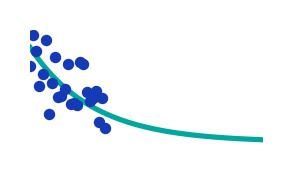

In [ ]:
x = np.arange(0, 15, step=0.2)
y = 2 * np.exp(-0.25 * x) + 34.4
jit = np.random.normal(loc=0, scale=0.2, size=y.shape)
jit[:len(jit)//2] = jit[:len(jit)//2] * 1.25
jit[:len(jit)//4] = jit[:len(jit)//4] * 1.45
plt.figure(figsize=(1, 0.5))
plt.scatter(x[:25], y[:25]+jit[:25], s=5)
plt.plot(x, y, linewidth=1.25, color="#00A79D", zorder=-1)
plt.axis("off")
plt.savefig("test.png", bbox_inches='tight', transparent=True, pad_inches=0.01, dpi=300)


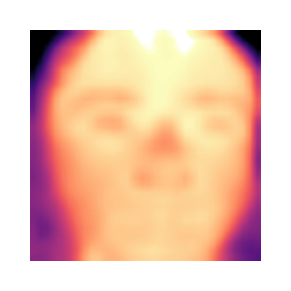

In [ ]:
plt.figure(figsize=(1, 1))
plt.imshow(sl, cmap=cmap, interpolation='bilinear')
plt.axis(False)
plt.savefig("temp_kendall.png", bbox_inches='tight', transparent=True, pad_inches=0)

# plt.colorbar()

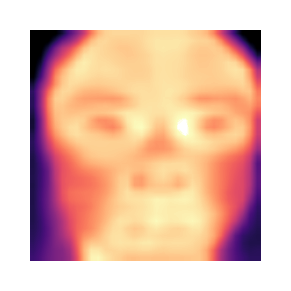

In [ ]:
plt.figure(figsize=(1, 1))
plt.imshow(base, cmap=cmap, interpolation='bilinear')
plt.axis(False)
plt.savefig("base_kendall.png", bbox_inches='tight', transparent=True, pad_inches=0)


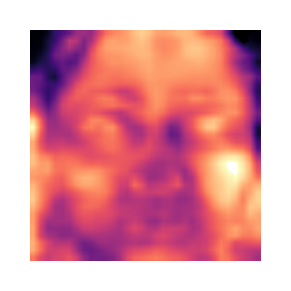

In [ ]:
plt.figure(figsize=(1, 1))
plt.imshow(sl - base, cmap=cmap, interpolation='bilinear')
plt.axis(False)
plt.savefig("sl_kendall.png", bbox_inches='tight', transparent=True, pad_inches=0)


## <font face="Avenir" size=4> 2. Train model: k-fold cross validation<font>

### <font face="Avenir" size=3> 2.1 Load experiment configurations from `parameters.csv` <font>

In [ ]:
folds = [0, 1, 2, 3, 4]

config_df = read_configs_csv(gc, SHEET_URL)
expts = []
for _, row in config_df.iterrows():
    folder, config = df_to_config(row)
    expts.append((folder, config))
expts = expts[-1:]
expts

[('classifier',
  ExptConfig(model='resunet', batch_size=32, epochs=12, lr=0.005, fever_prob=0.5, sl_weight=1.0, lpips_weight=1.0, mae_temp_weight=1.0, grad_clip=10.0))]

### <font face="Avenir" size=3> 2.2 Training loop <font>

In [ ]:
def train_model(model, config, train_dl, val_dl, save_path):
    train_losses = []
    val_losses1 = []
    val_losses2 = []
    best_val_loss = np.inf

    device = next(model.parameters()).device
    model.train()
    optimizer = AdamW(model.parameters(), lr=config.lr)
    clip_val = config.grad_clip
    for epoch in range(0, config.epochs):
        epoch_loss = 0
        total = 0

        for input in train_dl:
            optimizer.zero_grad()
            images, label, _ = input
            images = images.to(device)
            label = label.to(device).float()
            temp = images[:, 0:1]
            base = images[:, 1:2]
            weight = (label[:, 1] * config.sl_weight + label[:, 0])

            est, logits = model(temp)
            weight = weight[:, None, None, None]

            loss = loss_fn(est, base, temp, epoch=epoch,
                           weight=weight,
                           lpips_weight=config.lpips_weight,
                           mae_temp_weight=config.mae_temp_weight)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_val)
            optimizer.step()
            epoch_loss += loss.item()
            total += 1
        epoch_loss = epoch_loss / total
        val_loss1 = calc_dl_loss(model, val_dl, device)
        val_loss2 = calc_dl_loss(model, val_dl, device, fn=forehead_loss_fn)

        train_losses.append(epoch_loss)
        val_losses1.append(val_loss1)
        val_losses2.append(val_loss2)

        if epoch >= 3 and val_loss2 < best_val_loss:
            torch.save(model.state_dict(), f'{save_path}/best_weights.pth')
            best_val_loss = val_loss2
            print(f'saving {epoch+1} ...')
        print(f'Epoch: {str(epoch + 1):<2}  |  Train: {epoch_loss:.4f}  |  Val full: {val_loss1:.4f}  forehead: {val_loss2:.4f}')

    train_losses = np.array(train_losses)
    val_losses1 = np.array(val_losses1)
    val_losses2 = np.array(val_losses2)
    np.save(f'{save_path}/train_losses.npy', train_losses)
    np.save(f'{save_path}/val_losses.npy', val_losses1)
    np.save(f'{save_path}/val_losses_forehead.npy', val_losses2)

    return train_losses, val_losses1, val_losses2

******************* ./saves/classifier/fold_0 *******************
ResUNet
Epoch: 1   |  Train: 0.4790  |  Val full: 0.8815  forehead: 0.9743
Epoch: 2   |  Train: 0.3003  |  Val full: 0.9693  forehead: 1.0063
Epoch: 3   |  Train: 0.2931  |  Val full: 0.8583  forehead: 0.7369
saving 4 ...
Epoch: 4   |  Train: 0.2476  |  Val full: 1.0344  forehead: 1.0167
saving 5 ...
Epoch: 5   |  Train: 0.3028  |  Val full: 0.8941  forehead: 0.9726
saving 6 ...
Epoch: 6   |  Train: 0.3055  |  Val full: 0.9220  forehead: 0.7568
Epoch: 7   |  Train: 0.2348  |  Val full: 0.9306  forehead: 0.8187
saving 8 ...
Epoch: 8   |  Train: 0.2237  |  Val full: 0.8589  forehead: 0.7245
Epoch: 9   |  Train: 0.2399  |  Val full: 0.8494  forehead: 0.7663
saving 10 ...
Epoch: 10  |  Train: 0.2481  |  Val full: 0.9320  forehead: 0.7192
Epoch: 11  |  Train: 0.3335  |  Val full: 0.9500  forehead: 0.8380
Epoch: 12  |  Train: 0.2202  |  Val full: 0.9135  forehead: 0.7439
**********  cool: 0.8781   base: 0.4186   fever: 0.4685 

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch: 1   |  Train: 0.4326  |  Val full: 0.9686  forehead: 1.0532
Epoch: 2   |  Train: 0.2894  |  Val full: 0.9760  forehead: 1.0644
Epoch: 3   |  Train: 0.3892  |  Val full: 1.0153  forehead: 1.1268
saving 4 ...
Epoch: 4   |  Train: 0.2364  |  Val full: 0.9472  forehead: 1.0471
saving 5 ...
Epoch: 5   |  Train: 0.2356  |  Val full: 0.9688  forehead: 1.0320
saving 6 ...
Epoch: 6   |  Train: 0.2480  |  Val full: 0.9044  forehead: 0.8863
Epoch: 7   |  Train: 0.2690  |  Val full: 1.0906  forehead: 1.1228
Epoch: 8   |  Train: 0.2179  |  Val full: 0.9707  forehead: 0.9764
Epoch: 9   |  Train: 0.2122  |  Val full: 0.9273  forehead: 0.9510
Epoch: 10  |  Train: 0.2027  |  Val full: 0.9891  forehead: 1.1106
Epoch: 11  |  Train: 0.1984  |  Val full: 0.9443  forehead: 0.9907
Epoch: 12  |  Train: 0.1936  |  Val full: 0.9364  forehead: 1.0197
**********  cool: 0.9462   base: 0.2367   fever: 0.8279  **********
  
******************* ./saves/classifier/fold_2 *******************
ResUNet
Epoch: 1   |

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch: 1   |  Train: 0.4571  |  Val full: 1.1459  forehead: 1.0034
Epoch: 2   |  Train: 0.2883  |  Val full: 1.3039  forehead: 1.4262
Epoch: 3   |  Train: 0.3207  |  Val full: 1.1452  forehead: 1.1431
saving 4 ...
Epoch: 4   |  Train: 0.2284  |  Val full: 0.9471  forehead: 0.8630
Epoch: 5   |  Train: 0.2950  |  Val full: 1.1511  forehead: 1.1008
Epoch: 6   |  Train: 0.2186  |  Val full: 1.2391  forehead: 1.2672
Epoch: 7   |  Train: 0.2355  |  Val full: 1.0435  forehead: 1.0268
Epoch: 8   |  Train: 0.2056  |  Val full: 1.0304  forehead: 0.9282
Epoch: 9   |  Train: 0.2344  |  Val full: 1.0857  forehead: 1.0718
Epoch: 10  |  Train: 0.2277  |  Val full: 1.1209  forehead: 1.0846
Epoch: 11  |  Train: 0.1985  |  Val full: 1.0686  forehead: 1.0466
Epoch: 12  |  Train: 0.1964  |  Val full: 1.1367  forehead: 1.1235
**********  cool: 0.8291   base: 0.6247   fever: 1.1042  **********
  
******************* ./saves/classifier/fold_4 *******************
ResUNet


/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch: 1   |  Train: 0.4803  |  Val full: 1.0513  forehead: 0.9668
Epoch: 2   |  Train: 0.3081  |  Val full: 1.1393  forehead: 1.0947
Epoch: 3   |  Train: 0.2646  |  Val full: 1.0018  forehead: 0.8735
saving 4 ...
Epoch: 4   |  Train: 0.2545  |  Val full: 1.0010  forehead: 0.7946
Epoch: 5   |  Train: 0.2840  |  Val full: 0.9804  forehead: 0.8131
Epoch: 6   |  Train: 0.2226  |  Val full: 0.9781  forehead: 0.9024
Epoch: 7   |  Train: 0.2759  |  Val full: 1.0378  forehead: 0.9562
Epoch: 8   |  Train: 0.2211  |  Val full: 1.0153  forehead: 0.8200
Epoch: 9   |  Train: 0.2753  |  Val full: 1.0083  forehead: 0.8997
Epoch: 10  |  Train: 0.2145  |  Val full: 0.9793  forehead: 0.8443
Epoch: 11  |  Train: 0.2089  |  Val full: 0.9861  forehead: 0.8909
Epoch: 12  |  Train: 0.2037  |  Val full: 1.0054  forehead: 0.8546
**********  cool: 0.8729   base: 0.7516   fever: 1.0798  **********
  


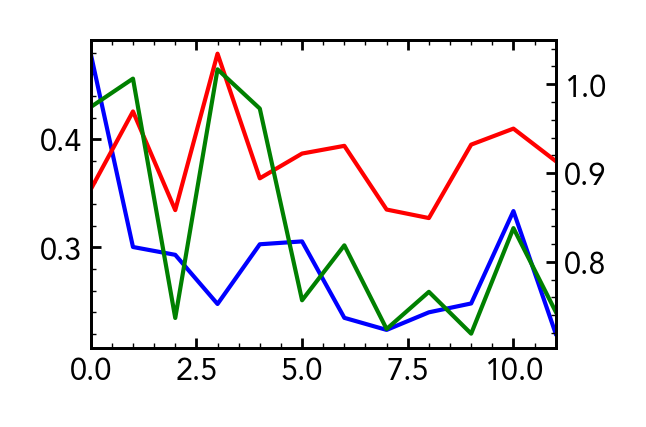

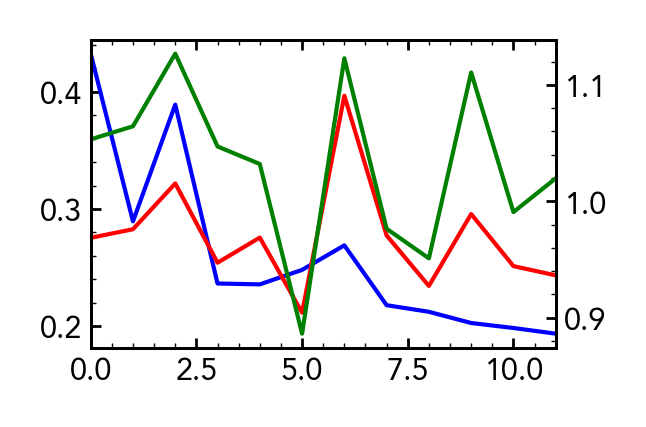

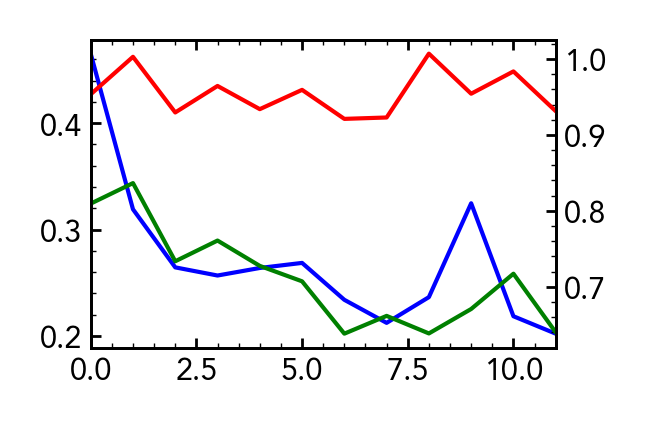

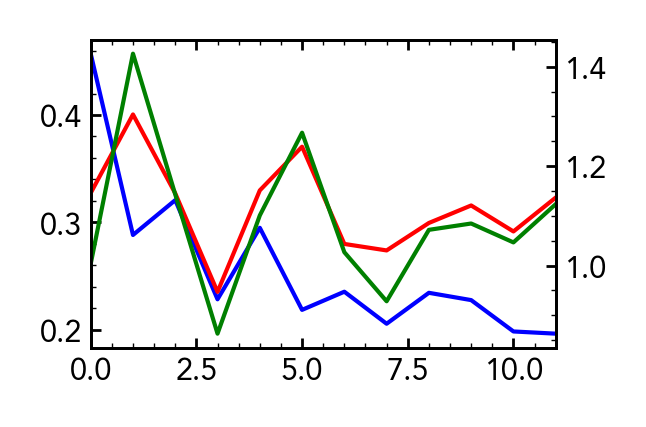

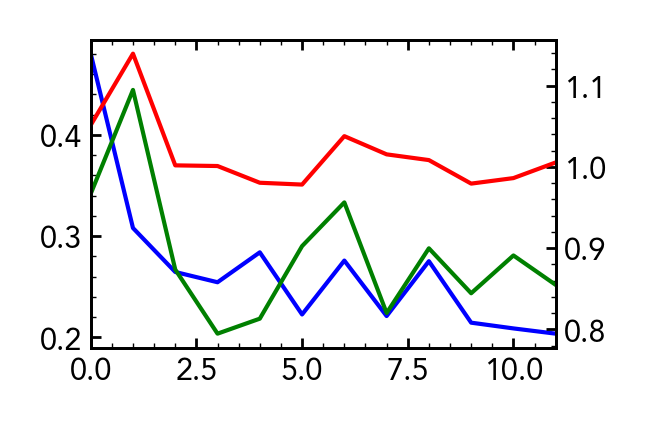

In [ ]:
from resunet import ResUNet

for fold_num in folds:
    train_dl, val_dl = get_training_data(fold_num, config, dataset_dir, DATASET_IMS)

    for folder, config in expts:
        save_path = f'./saves/{folder}/fold_{fold_num}'
        print(f'******************* {save_path} *******************')
        os.makedirs(save_path, exist_ok=True)

        model = get_model(config.model, ch_mult=8).to(device)
        print(type(model).__name__)
        init_weights(model, 'xavier')
        train_losses, val_losses1, val_losses2 = train_model(model, config, train_dl, val_dl, save_path)

        model.eval()
        model.load_state_dict(torch.load(save_path + f'/best_weights.pth'))
        forehead_losses = get_session_loss(model, fold_num)
        save_forehead_loss(forehead_losses, folder, save_path)

        plot_epoch_losses(train_losses, val_losses1, val_losses2, save_path)
        # Load the best model and display val recons
        # val_recons = dataset_recons(val_dl.dataset.ids, dataset_dir, DATASET_IMS, model)
        # plot_images(val_recons, save_path, cmap=cmap)
        print('  ')


### <font face="Avenir" size=3> 2.3 Classifier training loop <font>

In [ ]:
bceloss_fn = nn.CrossEntropyLoss()


def classifier_accuracy(unet_model, model, dl, device):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for data in dl:
            images, labels, _ = data
            images = images.to(device)
            labels = labels.to(device).float()[:, 0]
            temp = images[:, 0:1]
            base = images[:, 1:2]
            latent = unet_model(temp, decode=False)
            outputs = model(latent)
            _, predicted = torch.max(outputs.data, 1)

            # all_labels += labels.view(-1).cpu().numpy()
            # all_preds += predicted.view(-1).cpu().numpy()

            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    model.train()
    return correct / total


def train_classifier_model(unet_model, model, config, train_dl, val_dl, save_path):
    train_losses = []
    val_losses = []
    best_val_loss = 0

    device = next(model.parameters()).device
    model.train()
    optimizer = Adam(model.parameters(), lr=config.lr)
    clip_val = config.grad_clip
    for epoch in range(0, 10):
        epoch_loss = 0
        total = 0

        for data in train_dl:
            optimizer.zero_grad()
            images, label, _ = data
            images = images.to(device)
            label = label.to(device).long()
            temp = images[:, 0:1]
            base = images[:, 1:2]
            with torch.no_grad():
                latent = unet_model(temp, decode=False)
            latent = latent.detach()
            logits = model(latent)

            loss = bceloss_fn(logits, label[:, 0])
            loss.backward()
            # torch.nn.utils.clip_grad_norm_(model.parameters(), clip_val)
            optimizer.step()
            epoch_loss += loss.item()
            total += 1
        epoch_loss = epoch_loss / total
        val_loss = classifier_accuracy(unet_model, model, val_dl, device)

        train_losses.append(epoch_loss)
        val_losses.append(val_loss)

        if epoch >= 3 and val_loss > best_val_loss:
            torch.save(model.state_dict(), f'{save_path}/classifier_best_weights.pth')
            best_val_loss = val_loss
            print(f'saving {epoch+1} ...')
        print(f'Epoch: {str(epoch + 1):<2}  |  Train: {epoch_loss:.4f}  |  Val full: {val_loss:.4f}')

    train_losses = np.array(train_losses)
    val_losses = np.array(val_losses)
    np.save(f'{save_path}/train_losses.npy', train_losses)
    np.save(f'{save_path}/val_losses.npy', val_losses)

    return train_losses, val_losses

In [ ]:
folds = ['test']

config_df = read_configs_csv(gc, SHEET_URL)
expts = []
for _, row in config_df.iterrows():
    folder, config = df_to_config(row)
    expts.append((folder, config))
expts = expts[-2:-1]
expts

[('final',
  ExptConfig(model='resunet', batch_size=32, epochs=20, lr=0.005, fever_prob=0.5, sl_weight=1.0, lpips_weight=1.0, mae_temp_weight=1.0, grad_clip=10.0))]

In [ ]:
from resunet import ResUNet
from classifier import Classifier

folder, config = expts[0]

for fold_num in folds:
    train_dl, val_dl = get_training_data(fold_num, config, dataset_dir, DATASET_IMS)

    unet_save_path = f'./saves/{folder}/fold_{fold_num}'
    print(f'Loading ResUNet from {unet_save_path}')
    unet_model = get_model(config.model, ch_mult=8).to(device)
    unet_model.eval()
    unet_model.load_state_dict(torch.load(unet_save_path + f'/best_weights.pth'))

    for param in unet_model.parameters():
        param.requires_grad = False

    for folder, config in expts:
        save_path = f'./saves/classifier/fold_{fold_num}'
        print(f'******************* {save_path} *******************')
        os.makedirs(save_path, exist_ok=True)

        model = Classifier().to(device)
        train_losses, val_losses = train_classifier_model(unet_model, model, config, train_dl, val_dl, save_path)
        print('  ')


Loading ResUNet from ./saves/final/fold_test
******************* ./saves/classifier/fold_test *******************
Epoch: 1   |  Train: 0.0482  |  Val full: 0.9419
Epoch: 2   |  Train: 0.0208  |  Val full: 0.9680
Epoch: 3   |  Train: 0.0374  |  Val full: 0.9718
saving 4 ...
Epoch: 4   |  Train: 0.0430  |  Val full: 0.9604
Epoch: 5   |  Train: 0.0033  |  Val full: 0.9417
Epoch: 6   |  Train: 0.0296  |  Val full: 0.9426
saving 7 ...
Epoch: 7   |  Train: 0.0036  |  Val full: 0.9724
Epoch: 8   |  Train: 0.0001  |  Val full: 0.9506
Epoch: 9   |  Train: 0.0002  |  Val full: 0.9386
Epoch: 10  |  Train: 0.0008  |  Val full: 0.8842
  


In [ ]:
all_labels = np.array([])
all_preds = np.array([])
model.eval()
with torch.no_grad():
    for data in val_dl:
        images, labels, _ = data
        images = images.to(device)
        labels = labels.to(device).float()[:, 0]
        temp = images[:, 0:1]
        base = images[:, 1:2]
        latent = unet_model(temp, decode=False)
        outputs = model(latent)
        _, predicted = torch.max(outputs.data, 1)

        all_labels = np.hstack([all_labels, labels.view(-1).cpu().numpy()])
        all_preds = np.hstack([all_preds, predicted.view(-1).cpu().numpy()])

from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(all_labels, all_preds)
class_accuracy = 100 * conf_mat.diagonal() / conf_mat.sum(1)
class_accuracy

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/alex.pth


In [ ]:
def get_corr_mae(df):
    est = df['est_base_forehead'].to_numpy().copy()
    est_classifier = df['est_base_forehead'].to_numpy().copy()
    gt = df['gt_base_forehead'].to_numpy()

    mask = df['est_label'] == 1
    est_classifier[mask] = gt[mask]
    return np.abs(est - gt).mean(), np.abs(est_classifier - gt).mean()


In [ ]:
config_df = read_configs_csv(gc, SHEET_URL)
expts = []
for _, row in config_df.iterrows():
    folder, config = df_to_config(row)
    expts.append((folder, config))
expt = expts[-2]

vals = []

fold_num = 0
folder, config = expt
for fold_num in ['test']:
    save_path = f'./saves/{folder}/fold_{fold_num}'
    _, val_dl = get_training_data(fold_num, config, dataset_dir, DATASET_IMS)
    print(f'Loading model from {save_path}')

    metadata_df = []
    for sid in val_dl.dataset.ids:
        metadata_path = lambda sid: f'{dataset_dir}/{sid}/metadata.csv'
        sub_metadata_df = pd.read_csv(metadata_path(sid))
        sub_metadata_df['sid'] = sid
        metadata_df += [sub_metadata_df]
    metadata_df = pd.concat(metadata_df)

    unet_model = get_model(config.model, ch_mult=8).to(device)
    unet_model.eval()
    unet_model.load_state_dict(torch.load(save_path + f'/best_weights.pth'))

    classifier_model = Classifier().to(device)
    classifier_model.eval()
    classifier_model.load_state_dict(torch.load(f'./saves/classifier/fold_{fold_num}/classifier_best_weights.pth'))

    # ----------------------------------------------------------------

    config.fever_prob = 0
    _, val_dl = get_training_data(fold_num, config, dataset_dir, DATASET_IMS)
    cols, data = save_model_results_csv(val_dl, unet_model, classifier_model, False)
    df = pd.DataFrame(data, columns=cols)
    df['sid'] = df['fname'].str.split('_').apply(lambda x: x[0] + '_' + x[1])
    df = df.merge(metadata_df, how='left', on='sid')
    for col in cols[1:]:
        df[col] = pd.to_numeric(df[col])
    vals += [get_corr_mae(df)]
    vals += [get_corr_mae(df[df['est_label'] == 0])]
    vals += [get_corr_mae(df[df['est_label'] == 1])]

    config.fever_prob = 1
    _, val_dl = get_training_data(fold_num, config, dataset_dir, DATASET_IMS, session_filter='base')
    cols, data = save_model_results_csv(val_dl, unet_model, classifier_model, True)
    df_fever = pd.DataFrame(data, columns=cols)
    df_fever['sid'] = df_fever['fname'].str.split('_').apply(lambda x: x[0] + '_' + x[1])
    df_fever = df_fever.merge(metadata_df, how='left', on='sid')

    df = pd.concat([df, df_fever])
    df.to_csv(f'./saves/classifier/{fold_num}.csv')

Loading model from ./saves/final/fold_test


In [ ]:
vals = np.array(vals)

In [ ]:
vals[2::3].mean(axis=0), vals[2::3].std(axis=0)

(array([0.23698971, 0.        ]), array([0., 0.]))

In [ ]:
vals[1::3].mean(axis=0), vals[1::3].std(axis=0)


(array([0.66701502, 0.66701502]), array([0., 0.]))

In [ ]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(df['est_label'].apply(int), df['gt_label'].apply(int))
class_accuracy = 100 * conf_mat.diagonal() / conf_mat.sum(1)
class_accuracy

array([97.56139744, 93.24009324])

## <font face="Avenir" size=4> 3. Train the final model<font>

In [ ]:
config_df = read_configs_csv(gc, SHEET_URL)
expts = []
for _, row in config_df.iterrows():
    folder, config = df_to_config(row)
    expts.append((folder, config))
expt = expts[-1]
assert expt[0] == 'final'
expt

('final',
 ExptConfig(model='resunet', batch_size=32, epochs=20, lr=0.005, fever_prob=0.5, sl_weight=1.0, lpips_weight=1.0, mae_temp_weight=1.0, grad_clip=10.0))

******************* ./saves/final/fold_test *******************
ResUNet


/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch: 1   |  Train: 0.3378  |  Val full: 0.7675  forehead: 0.6157
Epoch: 2   |  Train: 0.2352  |  Val full: 0.7751  forehead: 0.6287
Epoch: 3   |  Train: 0.2162  |  Val full: 0.7098  forehead: 0.6302
saving 4 ...
Epoch: 4   |  Train: 0.2035  |  Val full: 0.7271  forehead: 0.6397
Epoch: 5   |  Train: 0.1951  |  Val full: 0.7682  forehead: 0.6844
Epoch: 6   |  Train: 0.1953  |  Val full: 0.7753  forehead: 0.6552
Epoch: 7   |  Train: 0.1894  |  Val full: 0.7529  forehead: 0.6575
saving 8 ...
Epoch: 8   |  Train: 0.1886  |  Val full: 0.7320  forehead: 0.6319
Epoch: 9   |  Train: 0.1873  |  Val full: 0.7532  forehead: 0.6709
Epoch: 10  |  Train: 0.1863  |  Val full: 0.7391  forehead: 0.6442
Epoch: 11  |  Train: 0.1814  |  Val full: 0.7485  forehead: 0.6978
Epoch: 12  |  Train: 0.1802  |  Val full: 0.7318  forehead: 0.6607
Epoch: 13  |  Train: 0.1816  |  Val full: 0.7841  forehead: 0.7225
saving 14 ...
Epoch: 14  |  Train: 0.1793  |  Val full: 0.7158  forehead: 0.6202
Epoch: 15  |  Train: 0

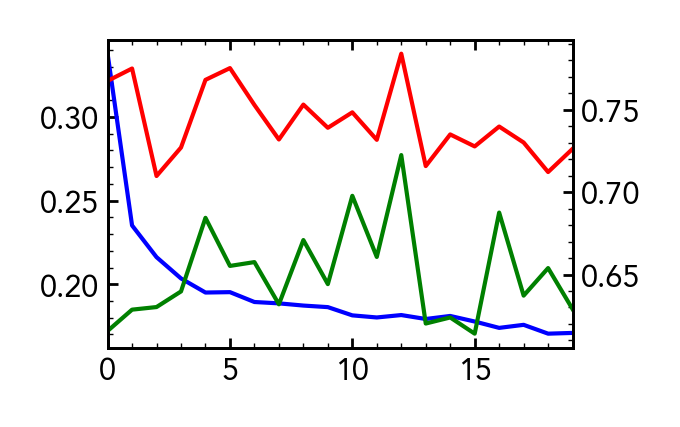

In [ ]:
fold_num = 'test'
folder, config = expt
train_dl, val_dl = get_training_data(fold_num, config, dataset_dir, DATASET_IMS)

save_path = f'./saves/{folder}/fold_{fold_num}'
print(f'******************* {save_path} *******************')
os.makedirs(save_path, exist_ok=True)

model = get_model(config.model, ch_mult=8).to(device)
print(type(model).__name__)
init_weights(model, 'xavier')
train_losses, val_losses1, val_losses2 = train_model(model, config, train_dl, val_dl, save_path)

model.eval()
model.load_state_dict(torch.load(save_path + f'/best_weights.pth'))
forehead_losses = get_session_loss(model, fold_num)
save_forehead_loss(forehead_losses, folder, save_path)
plot_epoch_losses(train_losses, val_losses1, val_losses2, save_path)
val_recons = dataset_recons(val_dl.dataset.ids, dataset_dir, DATASET_IMS, model)
plot_images(val_recons, save_path, cmap=cmap)


## <font face="Avenir" size=4> 4. Save results from final model <font>

In [ ]:
config_df = read_configs_csv(gc, SHEET_URL)
expts = []
for _, row in config_df.iterrows():
    folder, config = df_to_config(row)
    expts.append((folder, config))
expt = expts[-2]
assert expt[0] == 'final'

fold_num = 'test'
folder, config = expt
save_path = f'./saves/{folder}/fold_{fold_num}'
_, val_dl = get_training_data(fold_num, config, dataset_dir, DATASET_IMS)
print(f'Loading model from {save_path}')

metadata_df = []
for sid in val_dl.dataset.ids:
    metadata_path = lambda sid: f'{dataset_dir}/{sid}/metadata.csv'
    sub_metadata_df = pd.read_csv(metadata_path(sid))
    sub_metadata_df['sid'] = sid
    metadata_df += [sub_metadata_df]
metadata_df = pd.concat(metadata_df)

model = get_model(config.model, ch_mult=8).to(device)
model.eval()
model.load_state_dict(torch.load(save_path + f'/best_weights.pth'))

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/alex.pth
Loading model from ./saves/sl1_resunet/fold_0


FileNotFoundError: [Errno 2] No such file or directory: './saves/classifier/0/classifier_best_weights.pth'

In [ ]:
config.fever_prob = 0
_, val_dl = get_training_data(fold_num, config, dataset_dir, DATASET_IMS)
cols, data = save_model_results_csv(val_dl, model, False)
df = pd.DataFrame(data, columns=cols)
df['sid'] = df['fname'].str.split('_').apply(lambda x: x[0] + '_' + x[1])
df = df.merge(metadata_df, how='left', on='sid')

config.fever_prob = 1
_, val_dl = get_training_data(fold_num, config, dataset_dir, DATASET_IMS, session_filter='base')
cols, data = save_model_results_csv(val_dl, model, True)
df_fever = pd.DataFrame(data, columns=cols)
df_fever['sid'] = df_fever['fname'].str.split('_').apply(lambda x: x[0] + '_' + x[1])
df_fever = df_fever.merge(metadata_df, how='left', on='sid')

df = pd.concat([df, df_fever])
df.to_csv('./saves/final_test_results.csv')

## <font face="Avenir" size=4> 6. Save images for figure <font>

In [ ]:
# Load final model and dataloader
from utils import get_dataloader

config_df = read_configs_csv(gc, SHEET_URL)
expts = []
for _, row in config_df.iterrows():
    folder, config = df_to_config(row)
    expts.append((folder, config))
expt = expts[-2]
assert expt[0] == 'final'

fold_num = 'test'
folder, config = expt
save_path = f'./saves/{folder}/fold_{fold_num}'
_, val_dl = get_training_data(fold_num, config, dataset_dir, DATASET_IMS)
sids = val_dl.dataset.ids  # lazy way of getting test SIDs
print(f'Loading model from {save_path}')

model = get_model(config.model, ch_mult=8).to(device)
model.eval()
model.load_state_dict(torch.load(save_path + f'/best_weights.pth'))

Loading model from ./saves/final/fold_test


<All keys matched successfully>

In [ ]:
# pd.read_csv('./saves/final_test_results.csv').groupby('sid')['M'].mean()

In [ ]:
from matplotlib.colors import LinearSegmentedColormap

cmap = mpl.colormaps['magma']
colors = cmap(np.arange(0, 1.0001, step=0.01))
colors = np.vstack([np.array([0, 0, 0, 1])]*5 + [colors] + [np.array([1, 1, 1, 1])]*2 )
cmap = LinearSegmentedColormap.from_list('', colors)

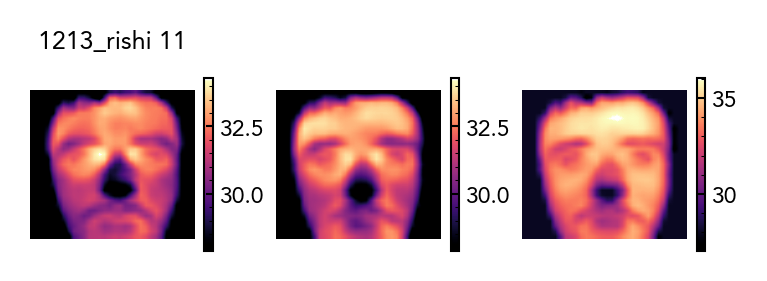

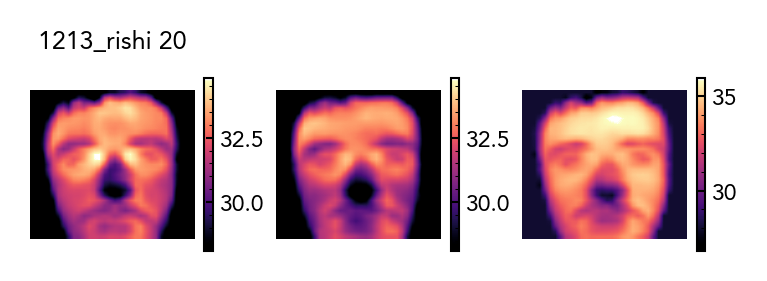

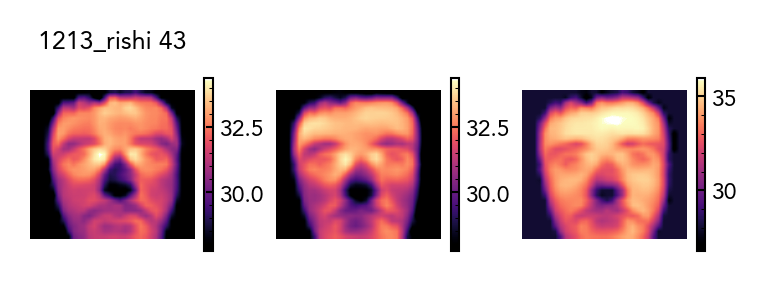

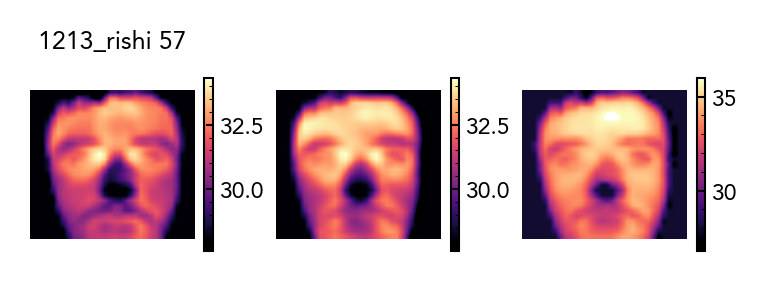

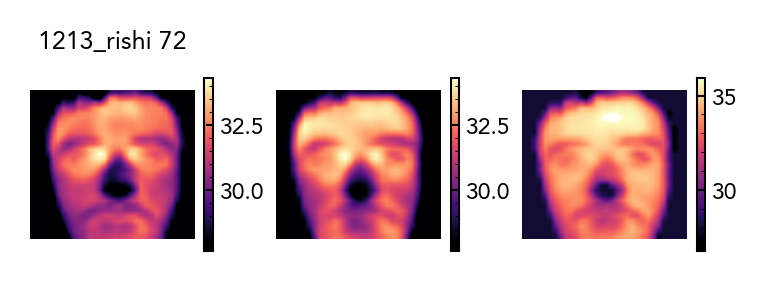

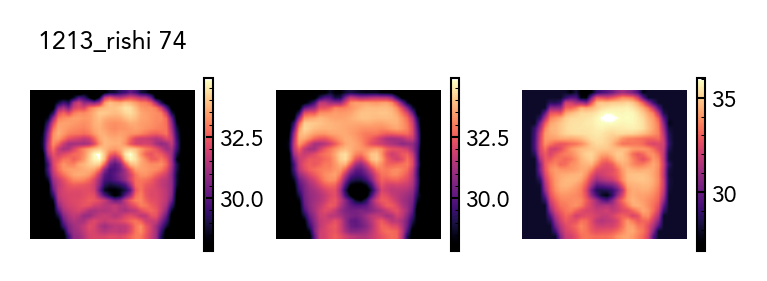

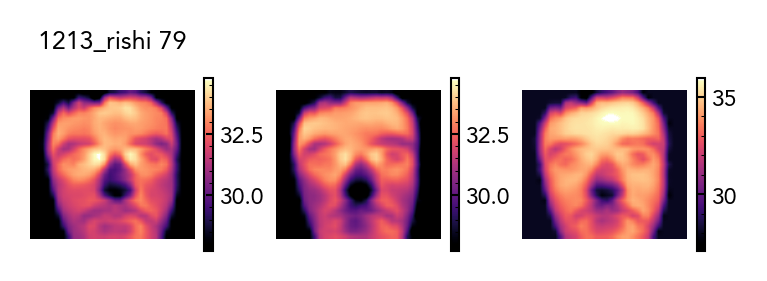

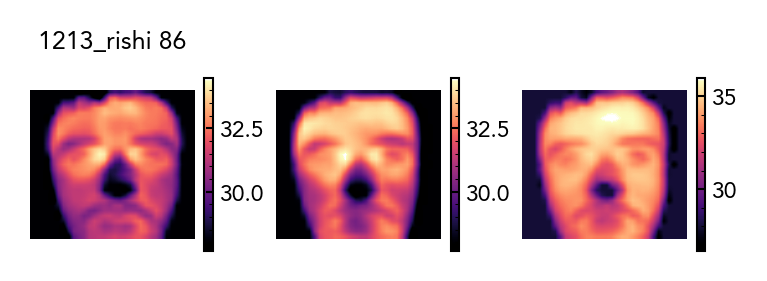

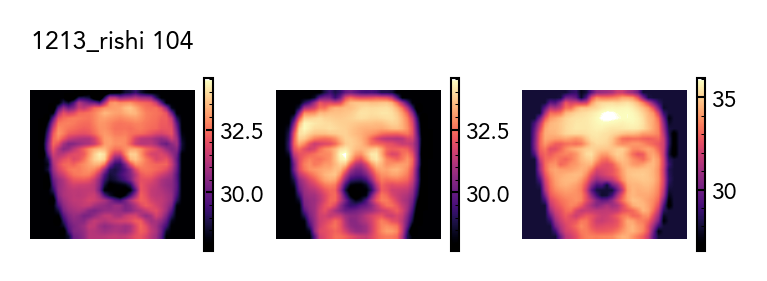

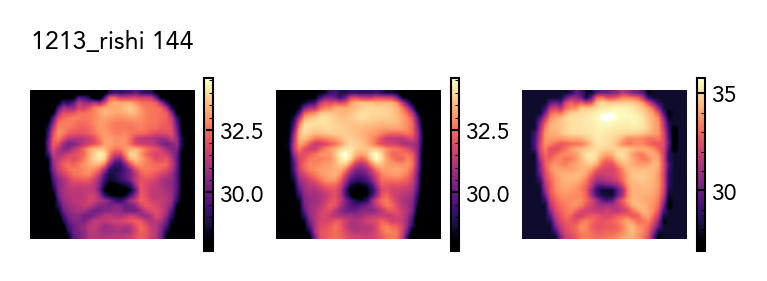

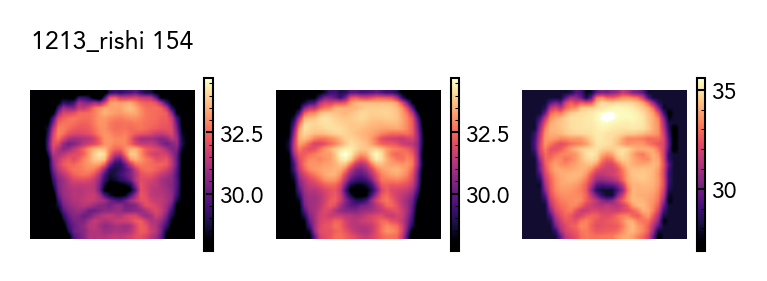

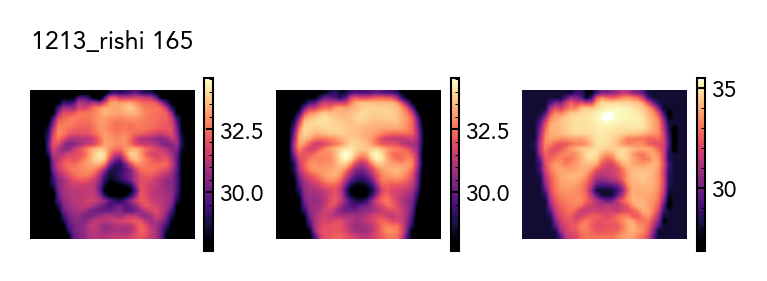

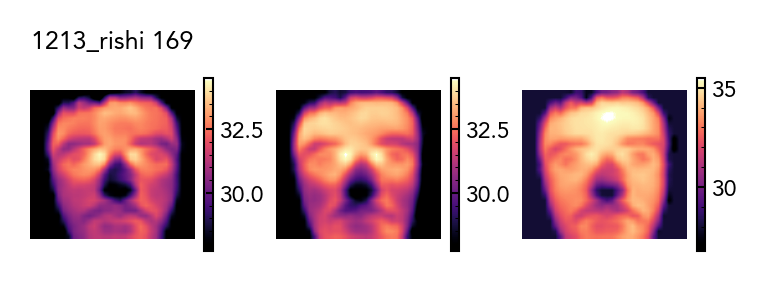

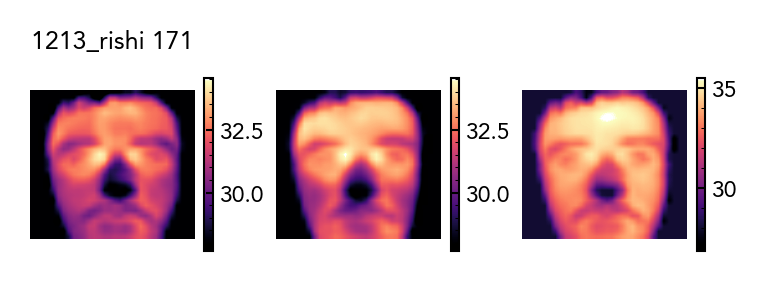

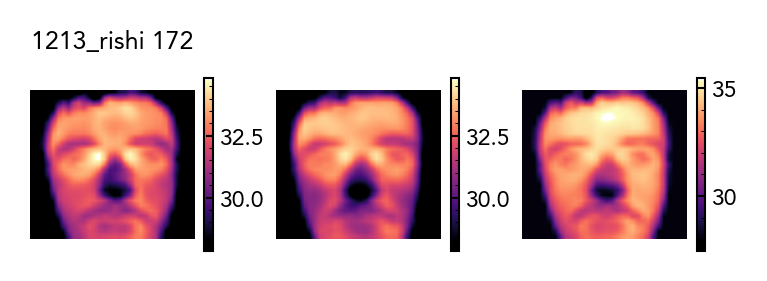

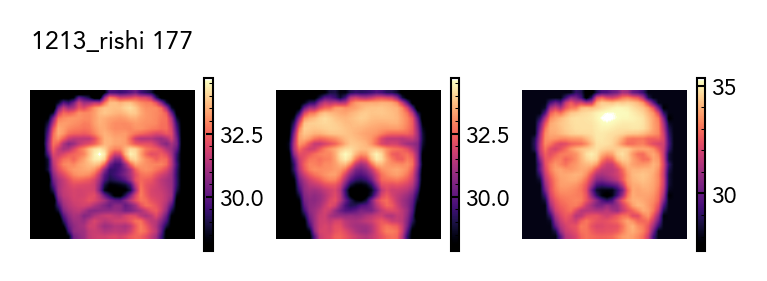

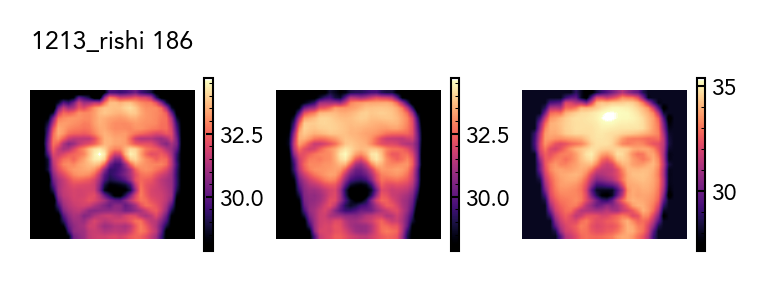

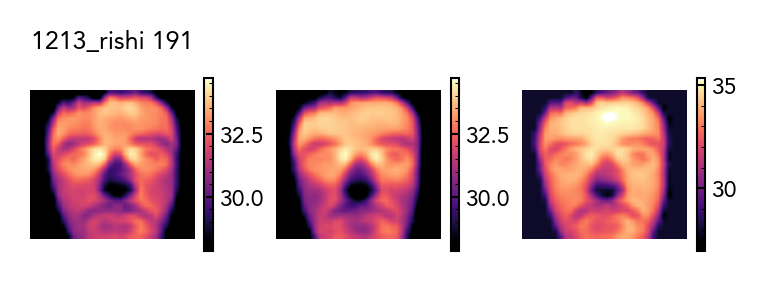

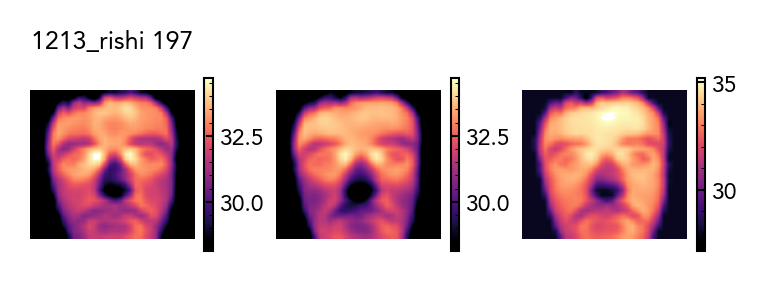

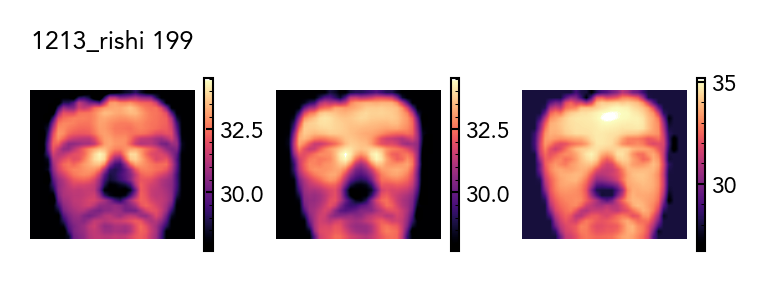

In [ ]:
# Visualize all images

config.fever_prob = 0
for sid in ['1213_rishi']: #'1213_rishi' '1106_agnes'
    dl = get_dataloader([sid], config, dataset_dir, DATASET_IMS,
                        train=False, session_filter='cool')
    n = len(dl.dataset)
    idxs = np.random.choice(range(200), min(n, 20), replace=False)
    idxs = np.sort(idxs)
    for i in idxs:
        images, _, _ = dl.dataset[i]
        images = images.unsqueeze(0).to(device)
        with torch.no_grad():
            est = model(images[:, 0:1])
        est = UNSCALE_FN(est)
        est_base = est[0, 0].cpu().numpy()
        est_sl = est[0, 0].cpu().numpy()
        images = UNSCALE_FN(images)
        temp = images[0, 0].cpu().numpy()
        base = images[0, 1].cpu().numpy()
        est_base = est_base[:-3]
        base = base[:-3]
        temp = temp[:-3]

        mask = (base < 28) & (est_base < 28)
        bg_fill = 28
        temp[mask] = bg_fill
        base[mask] = bg_fill
        est_base[mask] = bg_fill
        vmin = min(base.min(), est_base.min()) + 1
        vmax = max(base.max(), est_base.max())

        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(3, 0.75))
        kwargs = dict(vmin=vmin, vmax=vmax, cmap=cmap, interpolation='bilinear')
        im1 = ax1.imshow(base, **kwargs)
        ax1.axis('off')
        ax1.set_title(f'{sid} {i}')
        cb1 = fig.colorbar(im1, ax=ax1)
        # cb1.ax.tick_params(which='both', right=False, labelright=False)

        im2 = ax2.imshow(est_base, **kwargs)
        ax2.axis('off')
        cb2 = fig.colorbar(im2, ax=ax2)

        im3 = ax3.imshow(temp, cmap=cmap, interpolation='bilinear')
        ax3.axis('off')
        cb3 = fig.colorbar(im3, ax=ax3)

        # fig.savefig(f'./exports/test/{sid}_{i}.png', dpi=150)
        # plt.close(fig)

In [ ]:
df = pd.read_csv('./saves/final_test_results.csv')

def get_err_df(sid, cool_idx):
    row = df[df['fname'] == f'{sid}_cool_{cool_idx}']
    print(row)
    sl_err = np.abs(row['gt_temp_forehead'] - row['gt_base_forehead']).item()
    model_err = np.abs(row['est_base_forehead'] - row['gt_base_forehead']).item()
    return sl_err, model_err

def get_losses(gt, est):
    mask = (gt > 28) & (est > 28)
    crop_fn = lambda x: x[2:7, 13:-13]
    masked_mean = lambda x, m: (x * m).sum() / m.sum()
    face_loss = np.abs(est[mask] - gt[mask]).mean()
    est = crop_fn(est)
    gt = crop_fn(gt)
    mask = crop_fn(mask)
    forehead_loss = np.abs(masked_mean(est, mask) - masked_mean(gt, mask))
    return forehead_loss, face_loss


0.09178059895833712

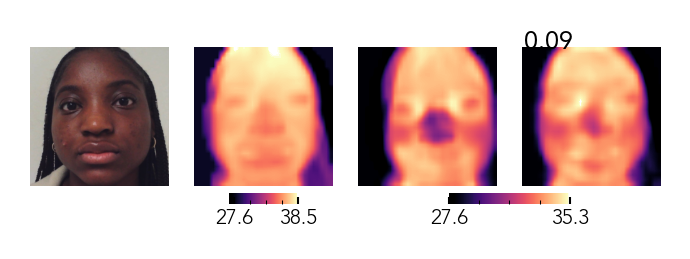

In [ ]:
# Visualize all images

sid, cool_idx = ('1106_agnes', 9)
# sl_err, model_err = get_err_df(sid, cool_idx)
config.fever_prob = 0
dl = get_dataloader([sid], config, dataset_dir, DATASET_IMS, train=False, session_filter='cool')
rgb = plt.imread(f'./{sid}_rgb.jpg')
images, _, _ = dl.dataset[cool_idx]
images = images.unsqueeze(0).to(device)
with torch.no_grad():
    cool_recon = model(images[:, 0:1])
cool_recon = UNSCALE_FN(cool_recon).cpu().numpy()
est_base = cool_recon[0, 0]
images = UNSCALE_FN(images).cpu().numpy()
temp = images[0, 0]
base = images[0, 1]

mask = (base < 28) & (est_base < 28)
bg_fill = 28
temp[mask] = bg_fill
base[mask] = bg_fill
est_base[mask] = bg_fill

temp = cv2.resize(temp[:-1], (32, 32))
base = cv2.resize(base[:-3], (32, 32))
est_base = cv2.resize(est_base[:-1], (32, 32))

vmin = min(base.min(), est_base.min()) + 1
vmax = max(base.max(), est_base.max())

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(3, 0.75), layout='compressed')
kwargs = dict(vmin=vmin, vmax=vmax, cmap=cmap, interpolation='bilinear')

ax1.imshow(rgb)
ax1.axis('off')

temp_im = ax2.imshow(temp, cmap=cmap, interpolation='bilinear')
ax2.axis('off')
cb1 = fig.colorbar(temp_im, ax=ax2, location='bottom', shrink=0.5, aspect=6)
cb1.outline.set_visible(False)
vals = [vmin, temp.max()]
cb1.set_ticks(vals)
cb1.set_ticklabels([f'{v:.1f}' for v in vals], fontdict={'fontsize': 5, 'fontweight': 'light'})
cb1.ax.xaxis.set_tick_params(pad=0.9)

base_im = ax3.imshow(base, **kwargs)
ax3.axis('off')
est_base_im = ax4.imshow(est_base, **kwargs)
ax4.axis('off')
cb2 = fig.colorbar(est_base_im, ax=[ax3, ax4], location='bottom', shrink=0.4, aspect=11)
cb2.outline.set_visible(False)
vals = [vmin, vmax]
cb2.set_ticks(vals)
cb2.set_ticklabels([f'{v:.1f}' for v in vals], fontdict={'fontsize': 5, 'fontweight': 'light'})
cb2.ax.xaxis.set_tick_params(pad=0.9)

loss, _ = get_losses(base, est_base)
ax4.text(0, 0, f'{loss:.2f}')
loss
# fig.savefig(f'./exports/{sid}_recon.eps', bbox_inches='tight', pad_inches=0.01)
# plt.close(fig)

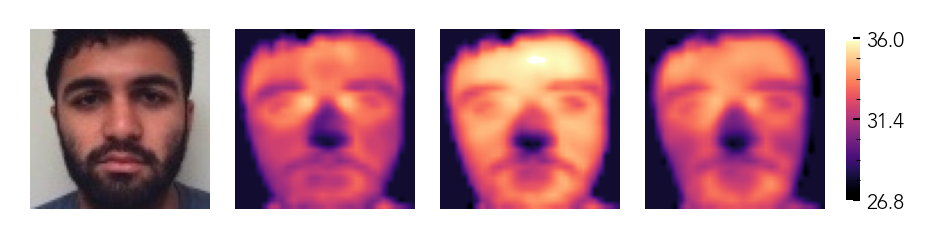

In [ ]:
# Visualize all images

sid, cool_idx = ('1213_rishi', 81)
config.fever_prob = 0

dl = get_dataloader([sid], config, dataset_dir, DATASET_IMS, train=False, session_filter='cool')
rgb = plt.imread(f'./{sid}_rgb.jpg')
images, _, _ = dl.dataset[cool_idx]
images = images.unsqueeze(0).to(device)
with torch.no_grad():
    cool_recon = model(images[:, 0:1])
cool_recon = UNSCALE_FN(cool_recon).cpu().numpy()
est_base = cool_recon[0, 0]
images = UNSCALE_FN(images).cpu().numpy()
temp = images[0, 0]
base = images[0, 1]

mask = (base < 28) & (est_base < 28)
bg_fill = 28
temp[mask] = bg_fill
base[mask] = bg_fill
est_base[mask] = bg_fill

vmin = min(base.min(), est_base.min()) + 0
vmax = max(base.max(), temp.max())

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(3, 0.75), layout='compressed')
kwargs = dict(vmin=vmin, vmax=vmax, cmap=cmap, interpolation='bilinear') #

ax1.imshow(rgb)
ax1.axis('off')

temp_im = ax2.imshow(base, **kwargs)
ax2.axis('off')
vals = [vmin, temp.max()]

base_im = ax3.imshow(temp, **kwargs)
ax3.axis('off')
est_base_im = ax4.imshow(est_base, **kwargs)
ax4.axis('off')
cb2 = fig.colorbar(est_base_im, ax=ax4, shrink=0.9, aspect=12, pad=0.12) #shrink=0.4, aspect=11)
cb2.outline.set_visible(False)
vals = [vmin, np.median([vmin, vmax]), vmax]
cb2.set_ticks(vals)
cb2.set_ticklabels([f'{v:.1f}' for v in vals], fontdict={'fontsize': 5, 'fontweight': 'light'})

fig.savefig(f'./exports/{sid}_recon_new.eps', bbox_inches='tight', pad_inches=0.01)
# plt.close(fig)

## <font face="Avenir" size=4>Other temperature states<font>

In [ ]:
# HOT AIR ---------------------------------------------------------------

sids = ['0425_hotair', '0425_exercise', '0426_makeupsun']
sid, cool_idx = (sids[0], 22)
config.fever_prob = 0
dl = get_dataloader([sid], config, dataset_dir, DATASET_IMS, train=False, session_filter='cool', clamp_sl=False)
images, _, _ = dl.dataset[cool_idx]
images = images.unsqueeze(0).to(device)
with torch.no_grad():
    cool_recon = model(images[:, 0:1])
cool_recon = UNSCALE_FN(cool_recon).cpu().numpy()
est_base = cool_recon[0, 0]
images = UNSCALE_FN(images).cpu().numpy()
temp = images[0, 0]
base = images[0, 1]
vmin = min(base.min(), est_base.min())
vmax = max(base.max(), temp.max())
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(3, 0.75), layout='compressed')
kwargs = dict(vmin=vmin, vmax=vmax, cmap=cmap, interpolation='bilinear')
ax1.axis('off')
ax1.imshow([[1.0]], vmin=0, vmax=1, cmap='gray')

temp_im = ax2.imshow(base, **kwargs)
ax2.axis('off')
vals = [vmin, temp.max()]

base_im = ax3.imshow(temp, **kwargs)
ax3.axis('off')
est_base_im = ax4.imshow(est_base, **kwargs)
ax4.axis('off')
cb2 = fig.colorbar(est_base_im, ax=ax4, shrink=0.9, aspect=12, pad=0.12) #shrink=0.4, aspect=11)
cb2.outline.set_visible(False)
vals = [vmin, np.median([vmin, vmax]), vmax]
cb2.set_ticks(vals)
cb2.set_ticklabels([f'{v:.1f}' for v in vals], fontdict={'fontsize': 5, 'fontweight': 'light'})

fig.savefig(f'./exports/{sid}_recon_new.eps', bbox_inches='tight', pad_inches=0.01)
plt.close(fig)

In [ ]:
from skimage.transform import resize

In [ ]:
# EXERCISE ---------------------------------------------------------------

sids = ['0425_hotair', '0425_exercise', '0426_makeupsun']
sid, cool_idx = (sids[1], 75)
config.fever_prob = 0

dl = get_dataloader([sid], config, dataset_dir, DATASET_IMS, train=False, session_filter='cool', clamp_sl=False)
images, _, _ = dl.dataset[cool_idx]
images = images.unsqueeze(0).to(device)
with torch.no_grad():
    cool_recon = model(images[:, 0:1])
cool_recon = UNSCALE_FN(cool_recon).cpu().numpy()
est_base = cool_recon[0, 0]
images = UNSCALE_FN(images).cpu().numpy()
temp = images[0, 0]
base = images[0, 1]
vmin = min(base.min(), est_base.min())
vmax = max(base.max(), temp.max())
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(3, 0.75), layout='compressed')
kwargs = dict(vmin=vmin, vmax=vmax, cmap=cmap, interpolation='bilinear')
ax1.axis('off')
ax1.imshow([[1.0]], vmin=0, vmax=1, cmap='gray')

temp_im = ax2.imshow(resize(base[:,:-2], (32, 32)), **kwargs)
ax2.axis('off')
vals = [vmin, temp.max()]

base_im = ax3.imshow(temp, **kwargs)
ax3.axis('off')
est_base_im = ax4.imshow(est_base, **kwargs)
ax4.axis('off')
cb2 = fig.colorbar(est_base_im, ax=ax4, shrink=0.9, aspect=12, pad=0.12) #shrink=0.4, aspect=11)
cb2.outline.set_visible(False)
vals = [vmin, np.median([vmin, vmax]), vmax]
cb2.set_ticks(vals)
cb2.set_ticklabels([f'{v:.1f}' for v in vals], fontdict={'fontsize': 5, 'fontweight': 'light'})

fig.savefig(f'./exports/{sid}_recon_new.eps', bbox_inches='tight', pad_inches=0.01)
plt.close(fig)

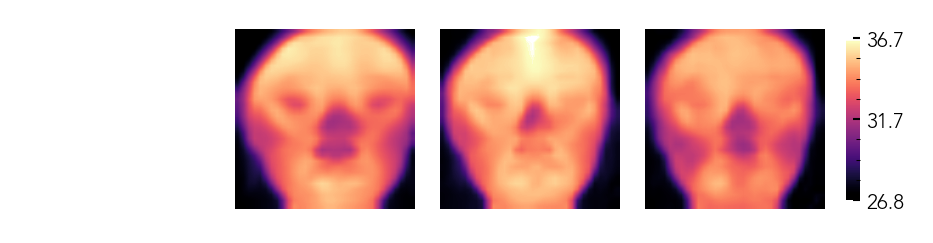

In [ ]:
# MAKEUP SL ---------------------------------------------------------------
sids = ['0425_hotair', '0425_exercise', '0426_makeupsun']
sid, cool_idx = (sids[2], 33)
config.fever_prob = 0
dl = get_dataloader([sid], config, dataset_dir, DATASET_IMS, train=False, session_filter='cool', clamp_sl=False)
images, _, _ = dl.dataset[cool_idx]
images = images.unsqueeze(0).to(device)
with torch.no_grad():
    cool_recon = model(images[:, 0:1])
cool_recon = UNSCALE_FN(cool_recon).cpu().numpy()
est_base = cool_recon[0, 0]
images = UNSCALE_FN(images).cpu().numpy()
temp = images[0, 0]
base = images[0, 1]
vmin = min(base.min(), est_base.min())
vmax = max(base.max(), temp.max())
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(3, 0.75), layout='compressed')
kwargs = dict(vmin=vmin, vmax=vmax, cmap=cmap, interpolation='bilinear')
ax1.axis('off')
ax1.imshow([[1.0]], vmin=0, vmax=1, cmap='gray')

temp_im = ax2.imshow(resize(base[:,:-2], (32, 32)), **kwargs)
ax2.axis('off')
vals = [vmin, temp.max()]

base_im = ax3.imshow(temp, **kwargs)
ax3.axis('off')
est_base_im = ax4.imshow(est_base, **kwargs)
ax4.axis('off')
cb2 = fig.colorbar(est_base_im, ax=ax4, shrink=0.9, aspect=12, pad=0.12) #shrink=0.4, aspect=11)
cb2.outline.set_visible(False)
vals = [vmin, np.median([vmin, vmax]), vmax]
cb2.set_ticks(vals)
cb2.set_ticklabels([f'{v:.1f}' for v in vals], fontdict={'fontsize': 5, 'fontweight': 'light'})

# fig.savefig(f'./exports/{sid}_recon_new.eps', bbox_inches='tight', pad_inches=0.01)
# plt.close(fig)


In [ ]:
from skimage.transform import resize


In [ ]:
from torchvision.transforms import Resize

resize = Resize((32, 32))

In [ ]:
# SL  ---------------------------------------------------------------

sid, cool_idx = ('1213_ellin', 23)

config.fever_prob = 0

dl = get_dataloader([sid], config, dataset_dir, DATASET_IMS, train=False, session_filter='cool', clamp_sl=False)
images, _, _ = dl.dataset[cool_idx]
images = images.unsqueeze(0).to(device)
# images = resize(images[:, :, 2:,1:-2])
with torch.no_grad():
    cool_recon = model(images[:, 0:1])
cool_recon = UNSCALE_FN(cool_recon).cpu().numpy()
est_base = cool_recon[0, 0]
images = UNSCALE_FN(images).cpu().numpy()
temp = images[0, 0]
base = images[0, 1]

vmin = min(base.min(), est_base.min())
vmax = max(base.max(), temp.max())
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(3, 0.75), layout='compressed')
kwargs = dict(vmin=vmin, vmax=vmax, cmap=cmap, interpolation='bilinear')
ax1.axis('off')
ax1.imshow([[1.0]], vmin=0, vmax=1, cmap='gray')

temp_im = ax2.imshow(base, **kwargs)
ax2.axis('off')
vals = [vmin, temp.max()]

base_im = ax3.imshow(temp, **kwargs)
ax3.axis('off')
est_base_im = ax4.imshow(est_base, **kwargs)
ax4.axis('off')
cb2 = fig.colorbar(est_base_im, ax=ax4, shrink=0.9, aspect=12, pad=0.12) #shrink=0.4, aspect=11)
cb2.outline.set_visible(False)
vals = [vmin, np.median([vmin, vmax]), vmax]
cb2.set_ticks(vals)
cb2.set_ticklabels([f'{v:.1f}' for v in vals], fontdict={'fontsize': 5, 'fontweight': 'light'})

fig.savefig(f'./exports/{sid}_recon_new.eps', bbox_inches='tight', pad_inches=0.01)
plt.close(fig)